The Log-Likelihood function of a binned poisson and gaussian is:

$l(n_i, y_i | \mu_i, s_i, \sigma_i) = \sum_{i=1}^N n_i \log{(\mu_i + s_i)} - N(\mu_i + s_i) -\frac{N}{2} \log{2 \pi \sigma_i^2} - \frac{1}{2}\left( \frac{1}{\sigma_i^2} (y_i - \mu_i)^2 \right)$

Let's split them up into several terms for convenience in computing:

Term 1: $n_i \log{(\mu_i + s_i)}$

Term 2: $ - N(\mu_i + s_i)$

Term 3: $-\frac{N}{2} \log{2 \pi \sigma_i^2}$

Term 4: $- \frac{1}{2}\left( \frac{1}{\sigma_i^2} (y_i - \mu_i)^2 \right)$
    

In [1]:
import autograd.numpy as np
from autograd.numpy import linalg
import matplotlib.pyplot as plt
from autograd.numpy.random import poisson

%matplotlib inline

def neg_log_like_PGP_binned(mu, s, ni, y, sigma):
    N = len(mu)
    if(len(s)!=N or len(y)!=N or len(ni)!=N or len(sigma)!=N):
        raise ValueError('Input arrays are not all the same length')
    result = 0.
    for i in range(N):
        result += ni[i] * np.log(mu[i] + s[i])
        result += -N*(mu[i] + s[i])
        result += -(N/2) * np.log(2. * np.pi * np.power(sigma[i],2))
        result += -(1./2) *  (np.power((1./sigma[i]),2) * np.power((y[i]-mu[i]),2))
        #result[i] = t1+t2+t3+t4
    return -result
    


Similarly, for the multivariate Gaussian case, we can write the log-likelihood function as:

$l(n_i, y_i | \mu_i, s_i, \Sigma) = -\frac{N}{2} \log(2 \pi) - \frac{N}{2} \log{|\Sigma|} - \frac{1}{2} \left( (\vec{y} - \vec{\mu})^T \Sigma^{-1} (\vec{y} - \vec{\mu}) \right) + \sum_{i=1}^N n_i \log{(\mu_i + s_i)} - N(\mu_i + s_i)$



In [2]:
def neg_log_like_PGP_MV(mu, s, ni, y, cov, invcov = None):
    if(invcov == None):
        invcov = linalg.inv(cov)
    N = len(mu)
    if(len(s)!=N or len(y)!=N or len(ni)!=N  or cov.shape!=(N,N)):
        raise ValueError('Input arrays are not all the same length')
    t1 = -(N/2.)*np.log(2*np.pi) - (N/2.) * np.log(linalg.det(cov))
    resid = (y-mu)[np.newaxis]
    t2 = (-(1./2) * np.dot(np.dot(resid,invcov),resid.T))[0][0]
    t3 = 0.
    for i in range(N):
        t3 += ni[i] * np.log(mu[i] + s[i])
        t3 -= N*(mu[i] + s[i])
    result = t1 + t2 + t3
    return -result
    

In [3]:
from autograd import grad

nln_bin_gminerad = grad(neg_log_like_PGP_binned)
nln_MV_grad = grad(neg_log_like_PGP_MV)

In [4]:
def f1(x):
    return (1./(np.exp(x-2)))

def f2(x):
    return 1./x

def f3(x):
    return 1.*np.exp(-3.*(x-0.7))

def f4(x):
    return (1./np.log(x+1))

def f5(x):
    return 1./(np.power(x+.3,2))



Construct kernel of the form:

$\Sigma (x,x') = Ae^{\left(\frac{d-(x+x')}{2a} \frac{-(x-x')^2}{e^{(bx+c)^2} +e^{(bx'+c)^2}}\right)}$

In [5]:
def makekernel(x, k, params, sigma = 0.):
    N = len(x)
    cov = np.empty((N,N))
    for i in range(N):
        for j in range(N):
            cov[i][j] = k(x[i],x[j], params)
    if len(sigma)>1:
        for i in range(N):
            cov[i][i] = sigma[i]**2
    return cov

#kernel with constant lengthscale but variable height
def kernel1(x1,x2, params):
    A = params[0]
    a = params[1]
    b = params[2]
    c = params[3]
    d = params[4]
    result = A * np.exp(-(((x1-x2)**2)/(((b*x1 + c)**2)+((b*x2 + c)**2)))+((d-(x1+x2))/(2.*a)))
    return result

def simulate(ytrue, cov):
    y0 = np.abs(np.random.multivariate_normal(ytrue, cov))
    mu = np.random.poisson(y0)
    return mu


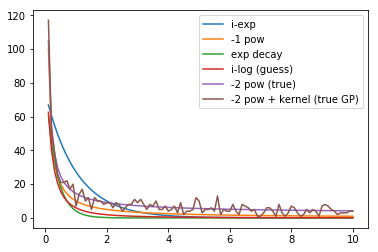

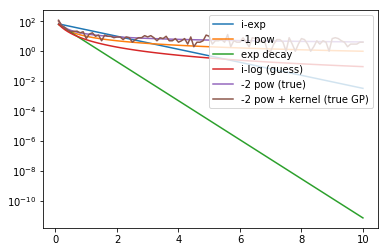

In [6]:
N= 100
x = np.linspace(.1,10,N)
scale = 10
kparams = [.5, 20, 1., 1., 1.]

y1 =  scale * f1(x)
y2 = scale * f2(x)
y3 = scale * f3(x)
yguess = scale * f5(x)
ytrue = scale * f4(x)

cov = makekernel(x, kernel1, kparams, sigma = np.sqrt(ytrue))
#n_GP = simulate(ytrue, cov)
n_GP = poisson(ytrue)

plt.figure()
plt.plot(x,y1, label = "i-exp")
plt.plot(x,y2, label = "-1 pow")
plt.plot(x,y3, label = "exp decay")
plt.plot(x,yguess, label = "i-log (guess)")
plt.plot(x,ytrue, label = "-2 pow (true)")
plt.plot(x,n_GP, label = "-2 pow + kernel (true GP)")
plt.legend(loc='upper right')

plt.figure()
plt.semilogy(x,y1, label = "i-exp")
plt.semilogy(x,y2, label = "-1 pow")
plt.semilogy(x,y3, label = "exp decay")
plt.semilogy(x,yguess, label = "i-log (guess)")
plt.semilogy(x,ytrue, label = "-2 pow (true)")
plt.semilogy(x,n_GP, label = "-2 pow + kernel (true GP)")
plt.legend(loc='upper right')

plt.show()

[276.86565798   5.35752616   1.15897181   5.40226018]


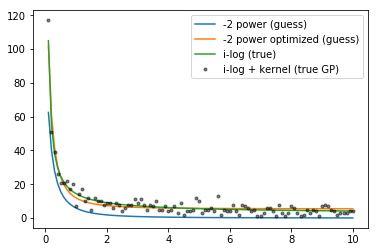

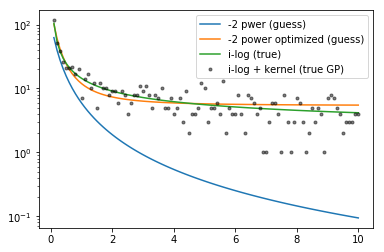

In [7]:
from scipy.optimize import curve_fit

def f4_opt(x, params):
    a = params[0]
    b = params[1]
    c = params[2]
    d = params[3]
    return ((1.*a)/(np.log(b*x + c)))+d

def f5_opt(x, a,b,c,d):
    return ((1.*a)/(np.power(b*x + c,2)))+d


p0 = np.array([1., 1., .3,0])
popt, pcov = curve_fit(f5_opt, x, ytrue, p0=[p0])
print popt

yguess_opt = f5_opt(x,popt[0],popt[1],popt[2],popt[3])

plt.figure()
plt.plot(x,yguess, label = "-2 power (guess)")
plt.plot(x,yguess_opt, label = "-2 power optimized (guess)")
plt.plot(x,ytrue, label = "i-log (true)")
plt.plot(x,n_GP,'k.', alpha = 0.5, label = "i-log + kernel (true GP)")
plt.legend(loc='upper right')

plt.figure()
plt.semilogy(x,yguess, label = "-2 pwer (guess)")
plt.semilogy(x,yguess_opt, label = "-2 power optimized (guess)")
plt.semilogy(x,ytrue, label = "i-log (true)")
plt.semilogy(x,n_GP,'k.', alpha = 0.5, label = "i-log + kernel (true GP)")
plt.legend(loc='upper right')

plt.show()

yguess = yguess_opt

In [8]:
n = poisson(ytrue)
sigma = np.sqrt(n+1)
boundarray = [(yguess[i] - 2*np.sqrt(yguess[i]), yguess[i]+2.*np.sqrt(yguess[i])) for i in range(N)]
signal0 = np.zeros(N)

In [21]:
from scipy.optimize import minimize
solnGP = minimize(neg_log_like_PGP_MV, yguess,  bounds = boundarray, args = (signal0, n_GP, yguess, cov), jac=nln_MV_grad, method='L-BFGS-B', options={'gtol':1e-20,'eps':1e-3})
print solnGP

      fun: 41803.13225134145
 hess_inv: <100x100 LbfgsInvHessProduct with dtype=float64>
      jac: array([98.4084157 , 98.65889755, 98.39974345, 98.43417438, 98.29545034,
       97.84945141, 97.23802132, 97.3788115 , 96.40259485, 98.41234868,
       96.59616513, 95.37759294, 96.89733258, 95.92820187, 98.05896558,
       95.16507143, 95.63461825, 95.32587652, 95.99454355, 95.24266142,
       94.98340123, 96.45331522, 94.48732822, 94.87946749, 97.29337242,
       95.84005377, 94.29482682, 94.11448262, 91.6984962 , 93.0063284 ,
       91.24887432, 93.46268135, 95.79655019, 93.17585222, 93.90293022,
       91.15720863, 95.46921234, 95.39570163, 93.48053565, 96.19360892,
       95.19285837, 93.2078785 , 97.01765105, 91.07484834, 97.94562074,
       95.91192492, 95.87110749, 94.80610279, 87.51471279, 89.49512073,
       96.77445287, 94.62801277, 94.58742921, 93.47270543, 95.59317959,
       85.75683719, 97.72735216, 94.40439517, 95.48007165, 95.45392481,
       90.94725232, 95.40389461, 97.

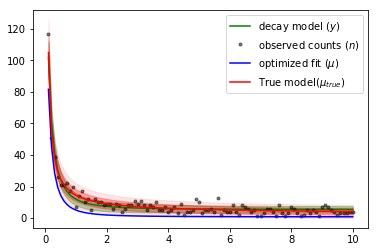

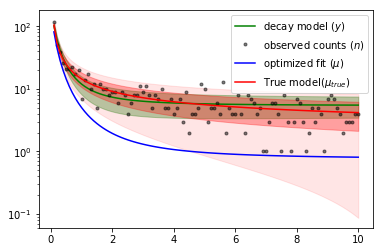

In [17]:
%matplotlib inline
plt.figure()

gp_std = np.sqrt(np.diag(cov))
yguess_std_low = np.empty(len(yguess))
ytrue_std_low = np.empty(len(yguess))
for i in range(len(yguess)):
    if yguess[i]-gp_std[i]<0.1: 
        yguess_std_low[i] = 0.1
    else:
        yguess_std_low[i] = yguess[i]-gp_std[i]
    if ytrue[i]-np.sqrt(ytrue[i])<0.1: 
        ytrue_std_low[i] = 0.1
    else:
        ytrue_std_low[i] = ytrue[i]-np.sqrt(ytrue[i])

plt.plot(x, yguess, 'g-', label = "decay model ($y$)")
plt.fill_between(x, yguess+gp_std, yguess-gp_std, color = 'g', alpha=0.3, edgecolor="none")
plt.plot(x, n_GP,'k.', label = "observed counts ($n$)", alpha = .5)
plt.plot(x, solnGP.x,'b-', label = "optimized fit ($\mu$)")
plt.plot(x, ytrue,'r-', label = "True model($\mu_{true}$)")
plt.fill_between(x, ytrue+np.sqrt(ytrue), ytrue_std_low, color = 'r', alpha=0.3, edgecolor="none")
plt.fill_between(x, ytrue+2*np.sqrt(ytrue), ytrue-2*np.sqrt(ytrue), color = 'r', alpha=0.1, edgecolor="none")
plt.legend(loc="upper right")

plt.figure()
plt.yscale('log')
plt.plot(x, yguess, 'g-', label = "decay model ($y$)")
plt.fill_between(x, yguess+gp_std, yguess_std_low, color = 'g', alpha=0.3, edgecolor="none")
plt.plot(x, n_GP,'k.', label = "observed counts ($n$)", alpha = 0.5)
plt.plot(x, solnGP.x,'b-', label = "optimized fit ($\mu$)")
plt.plot(x, ytrue,'r-', label = "True model($\mu_{true}$)")
plt.fill_between(x, ytrue+np.sqrt(ytrue), ytrue_std_low, color = 'r', alpha=0.3, edgecolor="none")
plt.fill_between(x, ytrue+2*np.sqrt(ytrue), ytrue-2*np.sqrt(ytrue), color = 'r', alpha=0.1, edgecolor="none")
plt.legend(loc="upper right")

plt.legend(loc="upper right")
plt.show()

4813.379820210474


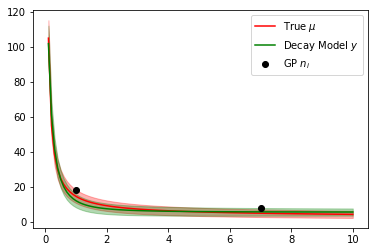

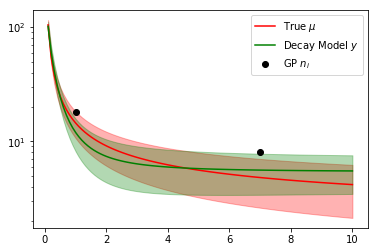

In [11]:
xtest = np.array([1., 7.])
y_g = scale*f5(xtest)
y_t = scale*f4(xtest)
n_bin = poisson(y_t)
cov_test = makekernel(xtest, kernel1, kparams, y_t)
print linalg.det(cov_test)
n_gp = n_bin
n_guess = y_t



plt.figure()
plt.plot(x, ytrue, 'r-', label = "True $\mu$")
plt.fill_between(x, ytrue+np.sqrt(ytrue), ytrue-np.sqrt(ytrue), color = 'r', alpha=0.3, edgecolor="none")
plt.plot(x, yguess, 'g-', label = "Decay Model $y$")
plt.fill_between(x, yguess+gp_std, yguess-gp_std, color = 'g', alpha=0.3, edgecolor="none")


plt.plot(xtest, n_gp, 'ko', label = "GP $n_i$")

plt.legend(loc="upper right")

plt.figure()
plt.yscale('log')
plt.plot(x, ytrue, 'r-', label = "True $\mu$")
plt.fill_between(x, ytrue+np.sqrt(ytrue), ytrue-np.sqrt(ytrue), color = 'r', alpha=0.3, edgecolor="none")
plt.plot(x, yguess, 'g-', label = "Decay Model $y$")
plt.fill_between(x, yguess+gp_std, yguess-gp_std, color = 'g', alpha=0.3, edgecolor="none")


plt.plot(xtest, n_gp, 'ko', label = "GP $n_i$")

plt.legend(loc="upper right")

plt.show()

In [12]:
stest = np.array([0.,0.])
ll_0 = -neg_log_like_PGP_MV(n_guess, stest, n_gp, y_g, cov_test)
llg_0 = -nln_MV_grad(n_guess, stest, n_gp, y_g, cov_test)
bound_test = [(y_g[i]-2*np.sqrt(y_g[i]),y_g[i]+2*np.sqrt(y_g[i])) for i in range(2)]

x3d = []
y3d = []
z3d = []
z3d_gradx = []
z3d_grady = []


#for mu1 in np.logspace(0.,np.log10(500), 30):
#    for mu2 in np.logspace(0.,np.log10(500), 30):
        
   
soln_test = minimize(neg_log_like_PGP_MV, [n_guess],  bounds = bound_test, args = (stest, n_gp, y_g, cov_test), jac=nln_MV_grad, method='L-BFGS-B')#, options={'maxfun':30000})
print soln_test

mu1_opt = soln_test.x[0]
mu2_opt = soln_test.x[1]

plot_range = 1.

if mu1_opt<plot_range:
    mu1_low = 0.
else:
    mu1_low = mu1_opt-plot_range

if mu2_opt<plot_range:
    mu2_low = 0.
else:
    mu2_low = mu2_opt-plot_range

for mu1 in np.linspace(mu1_low,mu1_opt+plot_range, 30):
    for mu2 in np.linspace(mu2_low,mu2_opt+plot_range, 30):
        x3d.append(mu1)
        y3d.append(mu2)
        mutest = np.array([mu1,mu2])
        ll = -neg_log_like_PGP_MV(mutest, stest, n_gp, y_g, cov_test)
        ll_grad = -nln_MV_grad(mutest, stest, n_gp, y_g, cov_test)
        z3d.append(ll)
        z3d_gradx.append(ll_grad[0])
        z3d_grady.append(ll_grad[1])
   


      fun: -9.50747266419516
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.97927642e-06, -5.55260916e+00])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 6
      nit: 5
   status: 0
  success: True
        x: array([8.93540194, 1.05402991])


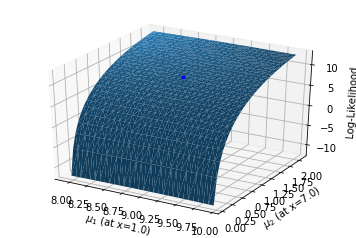

In [13]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

x3d = np.array(x3d)
y3d = np.array(y3d)
z3d = np.array(z3d)

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.set_xlabel('$\mu_1$ (at x=' + str(xtest[0])+')')
ax.set_ylabel('$\mu_2$ (at x=' + str(xtest[1])+')')
ax.set_zlabel('Log-Likelihood')

ax.plot_trisurf(x3d,y3d,z3d)
#ax.plot([n_guess[0]],[n_guess[1]], [ll_0], 'bo')
ax.plot([soln_test.x[0]],[soln_test.x[1]], [-soln_test.fun], 'b.')
plt.show()

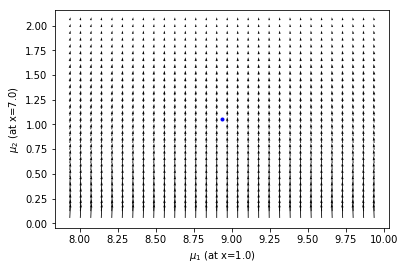

In [14]:
plt.figure()

z3d_gradx_a= np.array(z3d_gradx)
z3d_grady_a= np.array(z3d_grady)

z3d_gradx_log = np.sign(z3d_gradx_a) * np.log(abs(z3d_gradx_a)+1.)
z3d_grady_log = np.sign(z3d_grady_a) * np.log(abs(z3d_grady_a)+1.)


plt.quiver(x3d,y3d,z3d_gradx_log,z3d_grady_log)#, scale=1e3)
#plt.plot([n_guess[0]],[n_guess[1]], 'b.')
plt.plot([soln_test.x[0]],[soln_test.x[1]],  'b.')
plt.xlabel('$\mu_1$ (at x=' + str(xtest[0])+')')
plt.ylabel('$\mu_2$ (at x=' + str(xtest[1])+')')
plt.show()

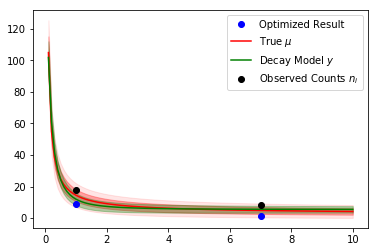

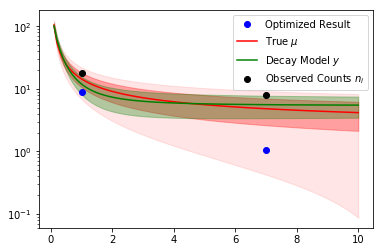

In [18]:
plt.figure()
plt.plot(xtest, soln_test.x, 'bo', label = "Optimized Result")
plt.plot(x, ytrue, 'r-', label = "True $\mu$")
plt.fill_between(x, ytrue+2*np.sqrt(ytrue), ytrue-2*np.sqrt(ytrue), color = 'r', alpha=0.1, edgecolor="none")
plt.fill_between(x, ytrue+np.sqrt(ytrue), ytrue-np.sqrt(ytrue), color = 'r', alpha=0.3, edgecolor="none")
plt.plot(x, yguess, 'g-', label = "Decay Model $y$")
plt.fill_between(x, yguess+gp_std, yguess-gp_std, color = 'g', alpha=0.3, edgecolor="none")


plt.plot(xtest, n_gp, 'ko', label = "Observed Counts $n_i$")

plt.legend(loc="upper right")

plt.figure()
plt.yscale('log')
plt.plot(xtest, soln_test.x, 'bo', label = "Optimized Result")
plt.plot(x, ytrue, 'r-', label = "True $\mu$")
plt.fill_between(x, ytrue+2*np.sqrt(ytrue), ytrue-2*np.sqrt(ytrue), color = 'r', alpha=0.1, edgecolor="none")
plt.fill_between(x, ytrue+np.sqrt(ytrue), ytrue-np.sqrt(ytrue), color = 'r', alpha=0.3, edgecolor="none")
plt.plot(x, yguess, 'g-', label = "Decay Model $y$")
plt.fill_between(x, yguess+gp_std, yguess-gp_std, color = 'g', alpha=0.3, edgecolor="none")


plt.plot(xtest, n_gp, 'ko', label = "Observed Counts $n_i$")

plt.legend(loc="upper right")

plt.show()